In [0]:
# Mount Google Grive for Colab
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# # Get the data from drive
# ! cp /content/drive/My\ Drive/Datasets/facial-keypoints-detection.zip /content
# ! unzip facial-keypoints-detection.zip
# ! rm -rf sample_data
# ! rm -rf facial-keypoints-detection.zip
# ! unzip training.zip
# ! unzip test.zip
# ! rm -rf training.zip
# ! rm -rf test.zip

In [0]:
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

In [5]:
# Print training data head
train_df.drop(['Image'], axis = 1).tail()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.265961,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.910346,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.754202,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447
7048,66.938311,43.424510,31.096059,39.528604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.069250,73.033339,NaN,NaN,NaN,NaN,NaN,NaN,45.900480,82.773096


In [6]:
train_df.shape

(7049, 31)

In [0]:
# constants
IMG_SIZE = 96
N_CHANNELS = 1 # Because of gray scale images
N_KEYPOINTS = 30
m = train_df.shape[0]

In [0]:
X_train = train_df['Image']
Y_train = train_df.drop(['Image'], axis = 1)

In [9]:
# check if training data contains NaN
print (Y_train.isnull().values.any())

True


In [0]:
# This contains NaN, replacing those values with mean of corresponding column
if Y_train.isnull().values.any():
    Y_train.fillna(Y_train.mean(), inplace=True)

In [11]:
# Check again for NaN
print (Y_train.isnull().values.any())

False


In [12]:
Y_train.tail()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
7044,67.402546,31.842551,29.746749,38.632942,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.265961,67.029093,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,47.910346,66.626011,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,49.462572,67.515161,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,50.754202,66.724988,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.065186,79.586447
7048,66.938311,43.424510,31.096059,39.528604,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,47.069250,73.033339,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,45.900480,82.773096


In [0]:
# Normalize the data
X_train = X_train.apply(lambda x: np.array(x.split()).astype(int)/255).to_numpy()
Y_train = Y_train.apply(lambda x: x / IMG_SIZE).to_numpy()

In [0]:
X_train = np.stack(X_train, axis = 0)

In [15]:
print (X_train.shape)
print (Y_train.shape)
# Shapes are (m, # of features) and (m, # of keypoints)

(7049, 9216)
(7049, 30)


In [16]:
# To feed in CNN, shapes need to be IMG_SIZE * IMG_SIZE
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print (X_train.shape)

(7049, 96, 96, 1)


In [0]:
# split train and validation set data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.20, random_state = 0)

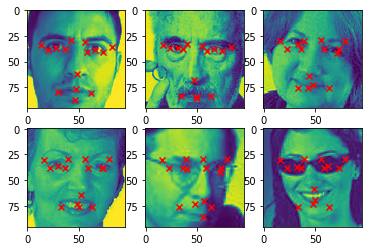

In [18]:
# Plot a few training images
_, ax = plt.subplots(nrows = 2, ncols = 3)
count = 0
for row in ax:
    for col in row:
        col.imshow(X_train[count].reshape(IMG_SIZE, IMG_SIZE))
        col.scatter((np.take(Y_train[count], range(0, N_KEYPOINTS, 2))) * IMG_SIZE, (np.take(Y_train[count], range(1, N_KEYPOINTS, 2))) * IMG_SIZE, color = 'red', marker = 'x')
        count += 1

plt.show()

In [0]:
# Define CNN layers
def conv_relu(inp, filter_size, n_filters):
    weights = tf.get_variable(name='weights', shape=[filter_size, filter_size, N_CHANNELS, n_filters], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    biases = tf.get_variable(name='biases', shape=[n_filters], initializer=tf.zeros_initializer())
    
    conv2d = tf.nn.conv2d(input=inp, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(tf.add(conv2d, biases))

def max_pool(inp, filter_size):
    return tf.nn.max_pool(value=inp, ksize=[1, filter_size, filter_size, 1], strides=[1, filter_size, filter_size, 1], padding = 'SAME')

def fully_connected(inp, n_neurons):
    weights = tf.get_variable(name='weights', shape=[inp.shape[1], n_neurons], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    biases = tf.get_variable(name='biases', shape=[n_neurons], initializer=tf.zeros_initializer())
    
    return tf.add(tf.matmul(inp, weights), biases)

def fully_connected_relu(inp, n_neurons):
    return tf.nn.relu(fully_connected(inp, n_neurons))

def dropout(inp, dropout_rate = 0.20):
    return tf.nn.dropout(x=inp, rate=dropout_rate, seed=0) # rate = 1 - keep_prob

In [0]:
def get_minibatches(X, Y, batch_size = 64):
    
    assert X.shape[0] == Y.shape[0]
    
    shuffeled_indices = np.random.RandomState(seed=0).permutation(X.shape[0])
    X_shuffeled = X[shuffeled_indices]
    Y_shuffeled = Y[shuffeled_indices]
    
    complete_batches = X.shape[0] // batch_size
    X_batches, Y_batches = [], []
    
    # First create all complete batches of size "batch_size"
    for batch in range(complete_batches):
        X_batches.append(X_shuffeled[batch * batch_size : (batch + 1) * batch_size])
        Y_batches.append(Y_shuffeled[batch * batch_size : (batch + 1) * batch_size])
        
    # In case of incomplete last batch
    if X.shape[0] % batch_size != 0:
        X_batches.append(X_shuffeled[batch_size * complete_batches : ])
        Y_batches.append(Y_shuffeled[batch_size * complete_batches : ])
        
    return X_batches, Y_batches

In [0]:
def get_placeholders(n_outputs):
    X = tf.placeholder(name='X', shape=[None, IMG_SIZE, IMG_SIZE, N_CHANNELS], dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape = [None, n_outputs], dtype=tf.float32)
    is_training = tf.placeholder(name='is_training', dtype=tf.bool)
    
    return X, Y, is_training

In [0]:
def calculate_cost(logits, labels):
    # Need to use one of the regression cost functions as this is a regression problem
    return tf.reduce_mean(tf.squared_difference(tf.squeeze(labels), tf.squeeze(logits)))

In [0]:
def get_validation_cost(session, X_valid, Y_valid):
    X_valid_placeholder = tf.placeholder(name='X_valid_ph', shape=[None, IMG_SIZE, IMG_SIZE, N_CHANNELS], dtype=tf.float32)
    Y_valid_placeholder = tf.placeholder(name='Y_valid_ph', shape=[None, N_KEYPOINTS], dtype = tf.float32)
    is_training_placeholder = tf.placeholder(name='is_training_ph', dtype=tf.bool)
    Z = forward_propagate(X_valid_placeholder, is_training_placeholder)
    cost = calculate_cost(Z, Y_valid_placeholder)
    return session.run(cost, feed_dict={X_valid_placeholder: X_valid, Y_valid_placeholder: Y_valid, is_training_placeholder:False})

In [0]:
def predict(X, session):
    X_pred = tf.placeholder(name='X_pred', shape=[None, IMG_SIZE, IMG_SIZE, N_CHANNELS], dtype=tf.float32)
    is_training_placeholder = tf.placeholder(name='is_training_ph', dtype=tf.bool)
    Z = forward_propagate(X_pred, is_training_placeholder)
    return session.run(Z, feed_dict={X_pred: X, is_training_placeholder:False})

In [0]:
def forward_propagate(X, is_training):
    
    with tf.variable_scope(name_or_scope='conv0', reuse=tf.AUTO_REUSE):
        X = conv_relu(X, filter_size=5, n_filters=32)
        X = max_pool(X, filter_size=2)
        # Apply dropout only if training the CNN
#         X = tf.cond(is_training, true_fn=lambda: dropout(X, dropout_rate=0.20), false_fn=lambda: X)

    with tf.variable_scope(name_or_scope='conv1', reuse=tf.AUTO_REUSE):
        X = conv_relu(X, filter_size=5, n_filters=64)
#         X = max_pool(X, filter_size=2)
        # Apply dropout only if training the CNN
#         X = tf.cond(is_training, true_fn=lambda: dropout(X, dropout_rate=0.20), false_fn=lambda: X)

    with tf.variable_scope(name_or_scope='conv2', reuse=tf.AUTO_REUSE):
        X = conv_relu(X, filter_size=3, n_filters=128)
        X = max_pool(X, filter_size=2)
        # Apply dropout only at training time
#         X = tf.cond(is_training, true_fn=lambda: dropout(X, dropout_rate=0.20), false_fn=lambda: X)

    
    # To feed this output in fully connected layer, flatten it
    shapes = X.get_shape().as_list()
    flattened = tf.reshape(X, [-1, shapes[1] * shapes[2] * shapes[3]])
    
    # Feed this flattened output to fullyconnected layer of size 1000 neurons
    with tf.variable_scope(name_or_scope='fc0', reuse=tf.AUTO_REUSE):
        X = fully_connected_relu(flattened, n_neurons=1000)

    # Feed this flattened output to fullyconnected layer of size 1000 neurons
    with tf.variable_scope(name_or_scope='fc1', reuse=tf.AUTO_REUSE):
        X = fully_connected_relu(X, n_neurons=1000)
        
    # Finally add the output layer
    with tf.variable_scope(name_or_scope='output', reuse=tf.AUTO_REUSE):
        Z = fully_connected(X, n_neurons=N_KEYPOINTS)
    
    return Z

In [0]:
def CNN_model(X_train, Y_train, X_valid, Y_valid, learning_rate=0.01, epochs = 20, batch_size=64):
    
    # Reset tensorflow graph
    tf.reset_default_graph()
    
    # First get the placeholders for data
    X, Y, is_training = get_placeholders(N_KEYPOINTS)
    
    # Propagate forward
    Z_L = forward_propagate(X, is_training)
    
    # Calculate the cost/loss
    cost = calculate_cost(Z_L, Y)
    
    # Propagate backward. Define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Create tensorflow session to run the graph built above
    with tf.Session() as session:
        
        session.run(tf.global_variables_initializer())
        train_costs, valid_costs = [], []
        
        # Run gradiant descent over given number of epochs
        for epoch in range(epochs):
            
            n_minibatches, batch_cost = m // batch_size, 0
            
            # Divide the training data into mini batches of given size to run mini batch gradiant descent
            X_minibatches, Y_minibatches = get_minibatches(X_train, Y_train, batch_size)
            
            # For each mini batch, take a step of gradiant descent
            for X_minibatch, Y_minibatch in zip(X_minibatches, Y_minibatches):
                
                _, minibatch_cost = session.run([optimizer, cost], feed_dict={X: X_minibatch, Y: Y_minibatch, is_training: True})
                batch_cost += minibatch_cost / n_minibatches
                
            valid_cost = get_validation_cost(session, X_valid, Y_valid)
            train_costs.append(batch_cost)
            valid_costs.append(valid_cost)
            print (f'Error after {epoch}th epoch: Training error: {batch_cost}, Validation set error: {valid_cost}')
            
        return train_costs, valid_costs, predict(X_valid, session)
        

In [143]:
train_costs, valid_costs, Y_preds = CNN_model(X_train, Y_train, X_valid, Y_valid, learning_rate=0.001, epochs=500, batch_size=20)

Error after 0th epoch: Training error: 0.008432744542667273, Validation set error: 0.0008628186769783497
Error after 1th epoch: Training error: 0.0007851485158673974, Validation set error: 0.0008453458431176841
Error after 2th epoch: Training error: 0.0007871924367050683, Validation set error: 0.0009311602334491909
Error after 3th epoch: Training error: 0.0007936253628444817, Validation set error: 0.0009379579569213092
Error after 4th epoch: Training error: 0.0007927815503618066, Validation set error: 0.0007969118887558579
Error after 5th epoch: Training error: 0.0007448123286105165, Validation set error: 0.0007538819336332381
Error after 6th epoch: Training error: 0.0007118665707821489, Validation set error: 0.0007147221476770937
Error after 7th epoch: Training error: 0.0006584692053531235, Validation set error: 0.0006149144028313458
Error after 8th epoch: Training error: 0.0006117492073992087, Validation set error: 0.0005650365492329001
Error after 9th epoch: Training error: 0.000555

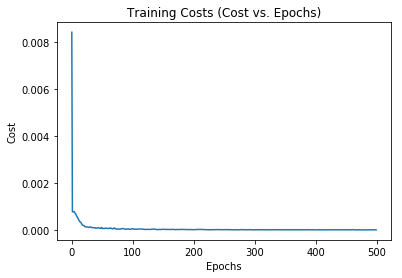

In [144]:
plt.plot(train_costs)
plt.title('Training Costs (Cost vs. Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

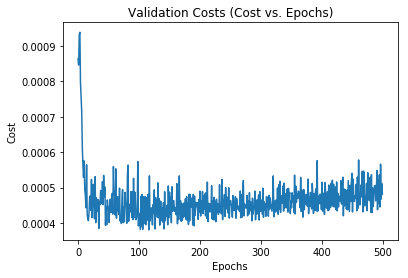

In [145]:
plt.plot(valid_costs)
plt.title('Validation Costs (Cost vs. Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

Y_pred: [0.7359011  0.4129554  0.28436756 0.40333223 0.615662   0.3958459
 0.7634907  0.393638   0.38198537 0.39656988 0.23355198 0.39601856
 0.58536685 0.30623865 0.8290638  0.3122245  0.40965107 0.30856347
 0.16604048 0.31682596 0.50369895 0.7224025  0.65811354 0.7919372
 0.3414854  0.7924669  0.4977064  0.75922644 0.49688467 0.91024673]
Y_valid: [0.74040625 0.4123355  0.27428725 0.39639988 0.61624312 0.39525784
 0.76385915 0.39278134 0.38179799 0.39572814 0.23317192 0.39618224
 0.58404701 0.30554873 0.8279461  0.30973813 0.40960559 0.3073229
 0.16532477 0.31696006 0.4934025  0.727065   0.65922641 0.79136161
 0.34271254 0.79353925 0.49974387 0.75957753 0.48941875 0.8465825 ]


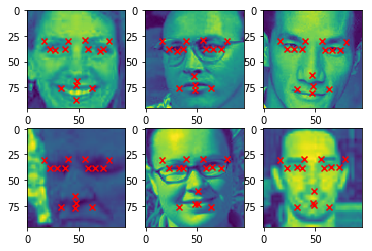

In [146]:
print (f'Y_pred: {Y_preds[0]}')
print (f'Y_valid: {Y_valid[0]}')

# Plot a few training images
_, ax = plt.subplots(nrows = 2, ncols = 3)
count = 0
for row in ax:
    for col in row:
        col.imshow(X_valid[count].reshape(IMG_SIZE, IMG_SIZE))
        col.scatter((np.take(Y_preds[count], range(0, N_KEYPOINTS, 2))) * IMG_SIZE, (np.take(Y_preds[count], range(1, N_KEYPOINTS, 2))) * IMG_SIZE, color = 'red', marker = 'x')
        count += 1

plt.show()